In [1]:
Experiments_file='/home/kate/Research/YearBuilt/Experiments/DwellingExperiments.xlsx'
AllExperiments_tab='Experiments'
Experiment_name='FinalFWC'
#Experiment configuration:  
#Predict on the same dataset/feature set but possible for different models (ModelFiles0
#1.each line in the file contains the model name and set of features to built a dataset for prediction
Experiment_Features_tab='%s Models'%Experiment_name
#2.ModelFiles: each line is a model name (Model) and full model file name (ModelData - model.tar.gz) in an S3 bucket
Experiment_ModelFiles_tab='%s ModelFiles'%Experiment_name

#Looks like Trial name should be unique in my environment, not in the experiment it belongs to
Trial_name='%s-Evaluation'%Experiment_name
 
bucket='kdproperty'
path_to_data_file='/Data/'

instance_type='ml.m5.xlarge'
instance_count=1

split_year='2020'

In [2]:
import boto3
import sys
import time
import pandas as pd
import numpy as np


import sagemaker
from sagemaker import get_execution_role
from sagemaker.processing import ScriptProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

from sagemaker.analytics import ExperimentAnalytics

In [3]:
region = boto3.session.Session().region_name
role = 'arn:aws:iam::757107622481:role/service-role/AmazonSageMaker-ExecutionRole-20200819T131882'
sagemaker_session = sagemaker.session.Session(default_bucket=bucket)

In [4]:
sys.path.append('/home/kate/Research/YearBuilt/Notebooks/Property')
import ExperimentsUtils as eu

In [5]:
#delete experiment and trials but not output files associated with jobs in experiments
eu.cleanup_experiment(Experiment_name)
#eu.cleanup_trial(Experiment_name, Trial_name)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


FinalFWC is a new experiment. nothing to delete


In [6]:
eu.create_experiment(Experiment_name)
eu.create_trial(Experiment_name,Trial_name)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [7]:
experiments = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=AllExperiments_tab)
target=experiments[experiments['Experiment']==Experiment_name]['Target'].values[0]
print(target)
data_file=experiments[experiments['Experiment']==Experiment_name]['Dataset'].values[0]
print(data_file)

hasclaim_water
dwelling_basedata_v4.csv


In [8]:
models_ModelFiles = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_ModelFiles_tab)
models_ModelFiles

,Model,Trial Component,ModelData
0,FWaterClaims,FWaterClaims-TrainingModels-FWaterClaims,s3://kdproperty/FWaterClaims-2020-12-31-20-15-...


In [9]:
models = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_Features_tab)
#take into account only first row
#all models are run on the same featureset and dataset
for index, row in models.iterrows():
    model=row['Model']
    print (index, ': Creating datasets for model %s'%model)
    featureset=row[1:51].tolist()
    featureset=[x for x in featureset if str(x) != 'nan']
    break
print(','.join(featureset))

0 : Creating datasets for model FWaterClaims
usagetype_encd,cova_deductible,cova_limit ,sqft,cal_year - yearbuilt,landlordind,water_risk_3_blk,constructioncd_encd


In [10]:
%%writefile evaluation.py
import argparse
import os
import pathlib
import pickle
import tarfile
import joblib
import numpy as np
import pandas as pd
import xgboost


#Evaluation metric
from sklearn.metrics import roc_auc_score
#To estimate models performance we need a custom gini function
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def create_fmap(ModelName,featureset):
    fmap_filename='%s.fmap'%ModelName
    outfile = open(fmap_filename, 'w')
    for i, feat in enumerate(featureset):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    return fmap_filename

if __name__=='__main__':
    
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_file', type=str)
    parser.add_argument('--split_year', type=int)       
    parser.add_argument('--model', type=str)
    parser.add_argument('--featureset', type=str)     
    parser.add_argument('--target', type=str)
    args, _ = parser.parse_known_args()    
    print('Received arguments {}'.format(args))
    
    featureset=args.featureset.split(',')
    model_path = '/opt/ml/processing/input/model/model.tar.gz'
    input_data_path = os.path.join('/opt/ml/processing/input', args.data_file)
    metrics_data_path = '/opt/ml/processing/output_metrics/metrics.csv'
    importance_data_path = '/opt/ml/processing/output_importance/importance.csv'
    prediction_data_path = '/opt/ml/processing/output_prediction/prediction.csv' 
    
    print('Reading model from file %s'%model_path)
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")
    
    model = pickle.load(open('xgboost-model','rb'))

    print('Reading dataset from %s'%input_data_path)
    dataset = pd.read_csv(input_data_path, error_bad_lines=False, index_col=False)
    
    print('Creating dataset for prediction')
    test_dataset = pd.DataFrame()
    for f in featureset:
        print(f)
        test_dataset[f]=dataset.eval(f)
        
    print('Creating DMatrix from dataset for prediction')
    X_test = xgboost.DMatrix(test_dataset.values)
    
    print('Prediction')
    predictions = model.predict(X_test)
    dataset[args.model]=predictions
    dataset[[args.model]].to_csv(prediction_data_path, header=True, index=False)
    
    print('Evaluation')
    test_roc_auc=roc_auc_score(dataset[(dataset.cal_year == args.split_year)][args.target], dataset[(dataset.cal_year == args.split_year)][args.model])
    train_roc_auc=roc_auc_score(dataset[(dataset.cal_year < args.split_year)][args.target], dataset[(dataset.cal_year < args.split_year)][args.model])
    
    test_gini=gini(dataset[(dataset.cal_year == args.split_year)][args.target],dataset[(dataset.cal_year == args.split_year)][args.model])/gini(dataset[(dataset.cal_year == args.split_year)][args.target],dataset[(dataset.cal_year == args.split_year)][args.target])
    train_gini=gini(dataset[(dataset.cal_year < args.split_year)][args.target],dataset[(dataset.cal_year < args.split_year)][args.model])/gini(dataset[(dataset.cal_year < args.split_year)][args.target],dataset[(dataset.cal_year < args.split_year)][args.target])
    
    TestingDataResults = pd.DataFrame(list(zip([args.model],[train_roc_auc],[test_roc_auc],[train_gini],[test_gini])), 
               columns =['Model','Train ROC-AUC','Test ROC-AUC','Train gini','Test gini'])
    
    TestingDataResults.to_csv(metrics_data_path, header=True, index=False)
    
    print('Feature Importance')
    
    fmap_filename=create_fmap(args.model,featureset)
    feat_imp = pd.Series(model.get_score(fmap=fmap_filename,importance_type='weight')).to_frame()
    feat_imp.columns=['Weight']
    feat_imp = feat_imp.join(pd.Series(model.get_score(fmap=fmap_filename,importance_type='gain')).to_frame())
    feat_imp.columns=['Weight','Gain']
    feat_imp = feat_imp.join(pd.Series(model.get_score(fmap=fmap_filename,importance_type='cover')).to_frame())
    feat_imp.columns=['Weight','Gain','Cover']
    feat_imp['FeatureName'] = feat_imp.index
    feat_imp['Model'] = args.model
    
    feat_imp.to_csv(importance_data_path, header=True, index=False)

Overwriting evaluation.py


In [11]:
from sagemaker.amazon.amazon_estimator import get_image_uri
processors=list()
image_uri = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='1.0-1') 

for index, row in models_ModelFiles.iterrows():
    model=row['Model']
    print (index, ': Prediction from model %s'%model)

    data_processor = ScriptProcessor(
    image_uri=image_uri,
    command=['python3'],
    instance_type=instance_type,
    instance_count=instance_count,
    base_job_name=model.replace('_','-'),
    role=role)

    data_processor.run(code='evaluation.py',
                        inputs=[ProcessingInput(
                        source='s3://%s%s'%(bucket,path_to_data_file+data_file),
                        destination='/opt/ml/processing/input'),
                                ProcessingInput(
                        source=row['ModelData'],
                        destination='/opt/ml/processing/input/model'),                              
                               ],
                        outputs=[ProcessingOutput(output_name='metrics', source='/opt/ml/processing/output_metrics', destination='s3://%s%soutput_metrics/%s'%(bucket,path_to_data_file,model)),
                        ProcessingOutput(output_name='importance', source='/opt/ml/processing/output_importance', destination='s3://%s%soutput_importance/%s'%(bucket,path_to_data_file,model)) ,
                        ProcessingOutput(output_name='prediction', source='/opt/ml/processing/output_prediction', destination='s3://%s%soutput_prediction/%s'%(bucket,path_to_data_file,model))
                                ],
                        arguments=['--data_file',data_file,                                 
                                 '--model',model,
                                 '--featureset', ','.join(featureset).replace(' ',''),
                                 '--target',target,
                                 '--split_year',split_year],
                        experiment_config = {
        'ExperimentName': Experiment_name ,
        'TrialName' : Trial_name,
        'TrialComponentDisplayName' : '%s-%s'%(Trial_name,model.replace('_','-')),},
                        wait=False
                        )
    processors.append(data_processor)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


0 : Prediction from model FWaterClaims


INFO:sagemaker:Creating processing-job with name FWaterClaims-2020-12-31-20-27-00-855



Job Name:  FWaterClaims-2020-12-31-20-27-00-855
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://kdproperty/Data/dwelling_basedata_v4.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://kdproperty/FWaterClaims-2020-12-31-20-15-33/output/model.tar.gz', 'LocalPath': '/opt/ml/processing/input/model', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-757107622481/FWaterClaims-2020-12-31-20-27-00-855/input/code/evaluation.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  

In [12]:
#wait till the rest of processing jobs complete
eu.wait_processing_jobs(processors=processors,check_every_sec=10,print_every_n_output=10,wait_min=60)

Processing job FWaterClaims-2020-12-31-20-27-00-855 status: InProgress
Continue waiting...
Processing job FWaterClaims-2020-12-31-20-27-00-855 status: InProgress
Continue waiting...
All Processing Jobs are Completed


In [13]:
trial_component_analytics = ExperimentAnalytics(
    experiment_name=Experiment_name
)
trial_comp_ds = trial_component_analytics.dataframe()
trial_ds=trial_comp_ds[trial_comp_ds['DisplayName'].str.contains(Trial_name)].copy()
trial_ds=trial_ds[['DisplayName','metrics - Value','importance - Value','prediction - Value']]
trial_ds.columns=['Trial Component','Model Scores','Feature Importance','Prediction Data']
trial_ds

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


,Trial Component,Model Scores,Feature Importance,Prediction Data
0,FinalFWC-Evaluation-FWaterClaims,s3://kdproperty/Data/output_metrics/FWaterClaims,s3://kdproperty/Data/output_importance/FWaterC...,s3://kdproperty/Data/output_prediction/FWaterC...


In [14]:
#Saving into the Experiment log location of the created  dataset
eu.SaveToExperimentLog(Experiments_file, '%s OutputData'%Experiment_name, trial_ds)

In [15]:
#to read data from S3 with pandas
import s3fs
s3 = s3fs.S3FileSystem()

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [16]:
OutputData = pd.read_excel(open(Experiments_file, 'rb'), sheet_name='%s OutputData'%Experiment_name[0:29])
OutputData

,Trial Component,Model Scores,Feature Importance,Prediction Data
0,FinalFWC-Evaluation-FWaterClaims,s3://kdproperty/Data/output_metrics/FWaterClaims,s3://kdproperty/Data/output_importance/FWaterC...,s3://kdproperty/Data/output_prediction/FWaterC...


In [17]:
Scores = pd.DataFrame()
for index, row in OutputData.iterrows():
    ModelScores=pd.read_csv(row['Model Scores']+'/metrics.csv',  error_bad_lines=False, index_col=False) 
    Scores = Scores.append(ModelScores, ignore_index=True)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [18]:
Scores=Scores.sort_values('Test ROC-AUC', ascending=False)
Scores

,Model,Train ROC-AUC,Test ROC-AUC,Train gini,Test gini
0,FWaterClaims,0.723898,0.710007,0.447795,0.420013


In [19]:
#Saving into the Experiment log 
eu.SaveToExperimentLog(Experiments_file, '%s Scores'%Experiment_name, Scores)

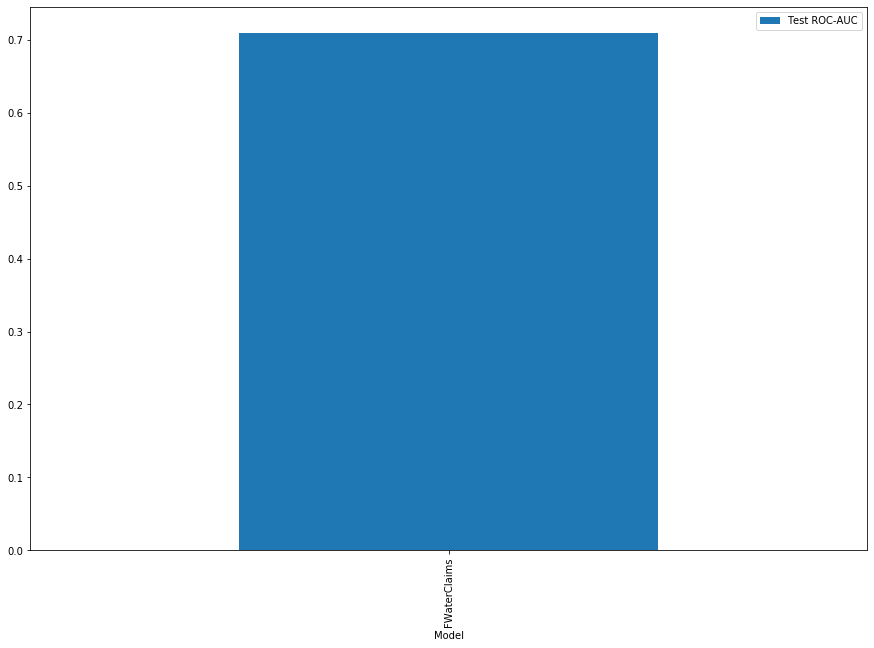

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches([15, 10])
Scores.plot.bar('Model', 'Test ROC-AUC',ax=plt.gca())

In [21]:
FeatureImportance = pd.DataFrame()
for index, row in OutputData.iterrows():
    ModelFeatureImportance=pd.read_csv(row['Feature Importance']+'/importance.csv',  error_bad_lines=False, index_col=False) 
    FeatureImportance = FeatureImportance.append(ModelFeatureImportance, ignore_index=True)

In [22]:
FeatureImportance.head()

,Weight,Gain,Cover,FeatureName,Model
0,1027,2.795279,1718.485591,cal_year-yearbuilt,FWaterClaims
1,816,1.866884,1188.267660,water_risk_3_blk,FWaterClaims
2,444,2.813730,1764.125248,cova_deductible,FWaterClaims
3,1078,1.219548,613.009188,cova_limit,FWaterClaims
4,1121,1.466397,559.878058,sqft,FWaterClaims


In [23]:
#Saving into the Experiment log 
eu.SaveToExperimentLog(Experiments_file, '%s FI'%Experiment_name, FeatureImportance)

In [24]:
#assuming each model is a fold and calculate average
FeatureImportance_df=FeatureImportance.groupby(['FeatureName'])['Gain'].mean().to_frame()
FeatureImportance_df.reset_index( drop=False, inplace=True )
FeatureImportance_df=FeatureImportance_df.sort_values('Gain', ascending=False)
FeatureImportance_df

,FeatureName,Gain
2,cova_deductible,2.813730
0,cal_year-yearbuilt,2.795279
7,water_risk_3_blk,1.866884
6,usagetype_encd,1.568402
4,landlordind,1.547352
5,sqft,1.466397
3,cova_limit,1.219548
1,constructioncd_encd,0.963656


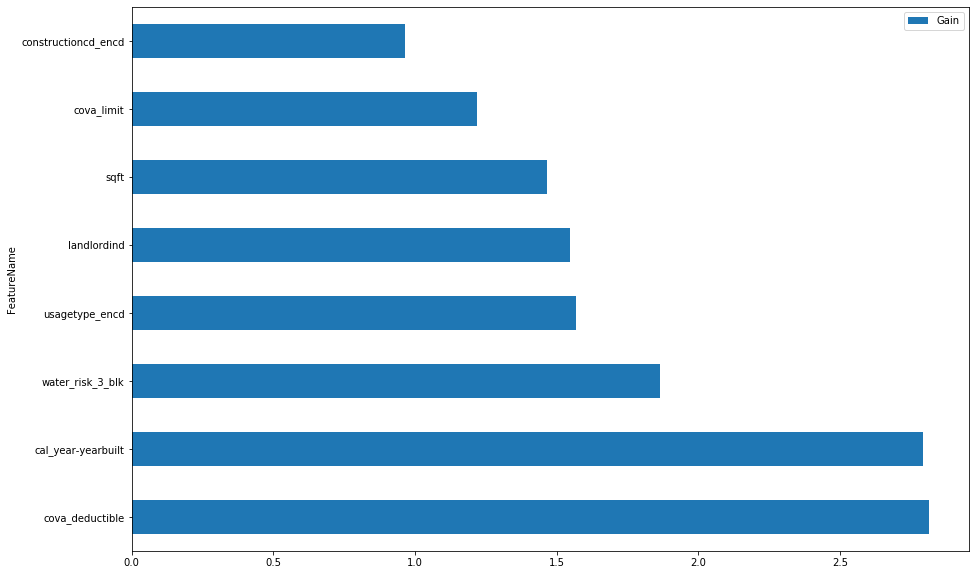

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches([15, 10])
FeatureImportance_df.plot.barh('FeatureName', 'Gain',ax=plt.gca())

In [26]:
#joining predicted data from each model to the original dataset
#maybe no need to download locally but rather run one more ScriptProcessor
#to have a complete dataset in S3 and load to Redshift directly
#For Shap Values we need a batch transform job

In [27]:
#original dataset
#can be read from S3: 's3://%s%s'%(bucket,path_to_data_file+data_file)
#or locally
dataset=pd.read_csv('/home/kate/Research/YearBuilt/Data/'+data_file,  error_bad_lines=False, index_col=False) 

In [28]:
columns=list()
for index, row in OutputData.iterrows():
    ModelPredictionData=pd.read_csv(row['Prediction Data']+'/prediction.csv',  error_bad_lines=False, index_col=False)
    columns.append(ModelPredictionData.columns[0])
    dataset = dataset.join(ModelPredictionData)

In [29]:
#evaluation all folds
#Evaluation metric
from sklearn.metrics import roc_auc_score
#To estimate models performance we need a custom gini function
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

In [30]:
dataset['Prediction']=0
for c in columns:
    dataset['Prediction']=dataset['Prediction']+dataset[c]
dataset['Prediction']=dataset['Prediction']/len(columns)    

In [31]:
model='Prediction'
test_roc_auc=roc_auc_score(dataset[(dataset.cal_year == split_year)][target], dataset[(dataset.cal_year == split_year)][model])
train_roc_auc=roc_auc_score(dataset[(dataset.cal_year < split_year)][target], dataset[(dataset.cal_year < split_year)][model])
    
test_gini=gini(dataset[(dataset.cal_year == split_year)][target],dataset[(dataset.cal_year == split_year)][model])/gini(dataset[(dataset.cal_year == split_year)][target],dataset[(dataset.cal_year == split_year)][target])
train_gini=gini(dataset[(dataset.cal_year < split_year)][target],dataset[(dataset.cal_year < split_year)][model])/gini(dataset[(dataset.cal_year < split_year)][target],dataset[(dataset.cal_year < split_year)][target])
    
TestingDataResults = pd.DataFrame(list(zip(['Final'],[train_roc_auc],[test_roc_auc],[train_gini],[test_gini])), 
               columns =['Model','Train ROC-AUC','Test ROC-AUC','Train gini','Test gini'])
TestingDataResults

  result = method(y)



ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
Scores=Scores.append(TestingDataResults, ignore_index=True)

In [ ]:
Scores=Scores.sort_values('Test ROC-AUC', ascending=False)
Scores

In [ ]:
#Saving into the Experiment log 
eu.SaveToExperimentLog(Experiments_file, '%s Scores'%Experiment_name, Scores)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches([15, 10])
Scores.plot.bar('Model', 'Test ROC-AUC',ax=plt.gca())